[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


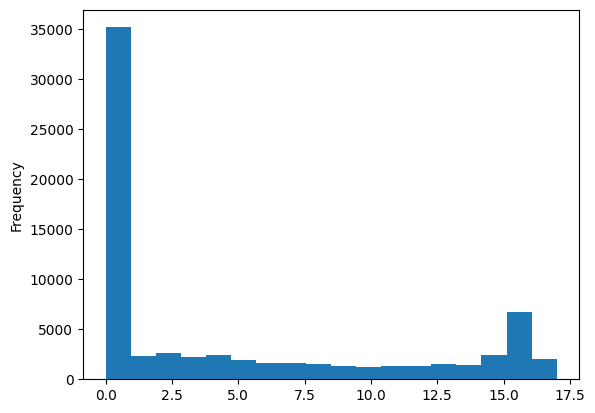

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


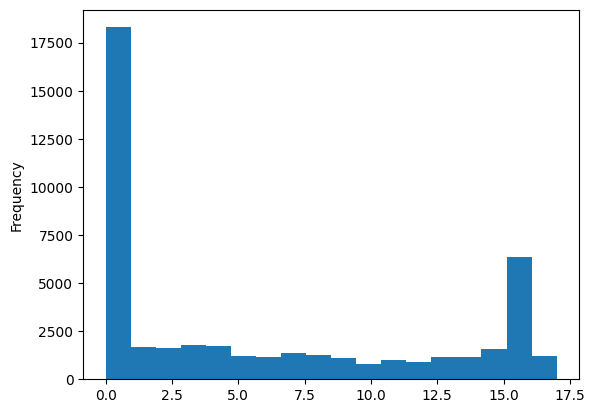

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


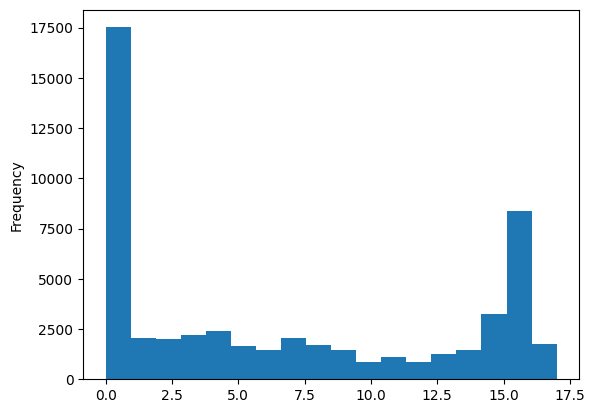

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


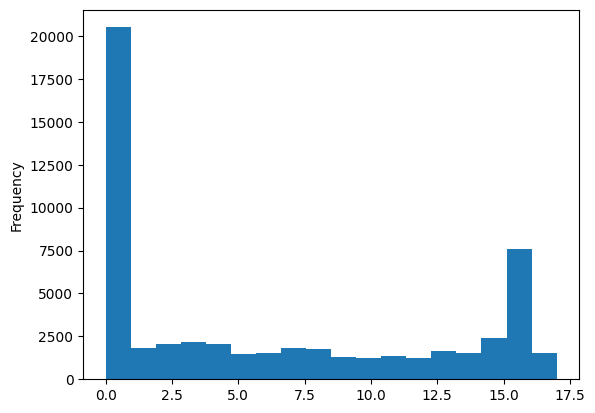

In [91]:
# read each file in datasets/Opportunity/by_subject:

import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

directory = 'datasets/Opportunity/by_subject'
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

for file in csv_files:
    # print(df.columns)
    file_path = os.path.join(directory, file)
    # Process the CSV file as needed
    # For example, you can use pandas to read the CSV file:
    df = pd.read_csv(file_path)
    
    # print(df.to_numpy()[0:6])
    # print(df.to_numpy()[:, 9])
    
    # data statistics in plt:
    print(np.unique(df['ML_Both_Arms']))
    df['ML_Both_Arms'].plot(kind='hist', bins=18)
    plt.show()


In [102]:
# read each file in datasets/Opportunity/by_subject:

import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

directory = 'raw_datasets/SPAR9X'
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

for file in csv_files:
    # print(df.columns)
    file_path = os.path.join(directory, file)
    # Process the CSV file as needed
    # For example, you can use pandas to read the CSV file:
    df = pd.read_csv(file_path)
    
    # print(df.to_numpy()[0:6])
    # print(df.to_numpy()[:, 9])
print(len(csv_files))


380


In [103]:

from utilities import *
sw = sliding_windows(50, 25)
X = []
Y = []


def replace_with_most_frequent(y):
    #NOTE: func used for OPPORTUNITY dataset by subject, if there are more than 1 label in a window, replace with the most frequent label
    # Iterate over each sample
    for i in range(y.size(0)):
        # Find unique labels and their counts
        unique_labels, counts = torch.unique(y[i], sorted=True, return_counts=True)
        # print(unique_labels, counts)
        if  len(unique_labels) > 1:
            # Find the most frequent label, exclude 0:
            most_frequent_label = unique_labels[1:][torch.argmax(counts[1:])]
            y[i] = most_frequent_label
    return y

for file in csv_files:
    # print(df.columns)
    file_path = os.path.join(directory, file)
    # Process the CSV file as needed
    # For example, you can use pandas to read the CSV file:
    df = pd.read_csv(file_path)
    print(df.to_numpy().shape)
    x, _ = sw(torch.tensor(df.to_numpy()), torch.tensor(df.to_numpy())) # sec para as placeholder, not used
    y = int(file.split('_')[1])

    
    X.append(x)
    Y.append(y)

X = torch.cat(X, dim=0)
# Y = torch.cat(Y, dim=0)
X.shape, Y.shape

for i in range(18):
    print(torch.sum(Y == i))

(1725, 12)


ValueError: invalid literal for int() with base 10: 'E9'

In [81]:
from sklearn.discriminant_analysis import StandardScaler
import torch
from torch.utils.data import Dataset
from livelossplot import PlotLosses

class StandardTransform(torch.nn.Module):
    def __init__(self, scaler='standard'):
        super(StandardTransform, self).__init__()
        if scaler == 'standard':
            self.scaler = StandardScaler()
        else:
            raise NotImplementedError('Only standard scaler is implemented')
        
    def __call__(self, data):
        data = self.scaler.transform(data)
        return data
    
    def fit(self, data):
        n_samples, n_time_steps, n_features = data.shape
        data_reshaped = data.reshape(-1, n_features)  # The shape becomes (n_samples * n_time_steps, n_features)
        self.scaler.fit(data_reshaped)
        print('Fitted with mean: {}, and std: {}'.format(self.scaler.mean_, np.sqrt(self.scaler.var_)))
        return self


class MultivariateTimeSeriesDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        if self.transform:
            return self.transform(self.X[index]), self.Y[index]
        return self.X[index], self.Y[index]

# Dataloader
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Split the dataset into train, valid, test sets:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=42)
train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=42)
# Initialize the StandardScaler
ST = StandardTransform().fit(train_X)




# Create dataloaders for train and test sets
train_dataloader = DataLoader(MultivariateTimeSeriesDataset(train_X, train_Y, transform=ST), batch_size=32, shuffle=True)
val_dataloader = DataLoader(MultivariateTimeSeriesDataset(valid_X, valid_Y, transform=ST), batch_size=32, shuffle=False)
test_dataloader = DataLoader(MultivariateTimeSeriesDataset(test_X, test_Y, transform=ST), batch_size=32, shuffle=False)


Fitted with mean: [-5.82982786e-01  4.87233879e-01  2.06254615e-01 -3.16177309e-04
  4.75643043e-04  3.23383596e-04], and std: [0.53780161 0.3189256  0.3854909  0.02150458 0.01562627 0.01892391]


In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch
from utilities import *
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
num_epochs = 100

import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=6, hidden_size=1024, num_layers=2, output_size=18):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
import torch.nn.functional as F
import math 


    
class TransformerModel(nn.Module):
    """Container module with an encoder, a recurrent or transformer module, and a decoder."""

    def __init__(self, ntoken=6, ninp=64, nhead=1, nhid=128, nlayers=6, dropout=0.1, activation='relu'):
        super(TransformerModel, self).__init__()
        self.input_emb = nn.Linear(ntoken, ninp)
        self.ninp = ninp
        self.relu = nn.ReLU()
        encoder_layer = nn.TransformerEncoderLayer(d_model=ninp, nhead=nhead, dim_feedforward=nhid, dropout=dropout, activation=activation, batch_first=True)
        encoder_norm = nn.LayerNorm(ninp)   
        self.transformer_encoder = TransformerEncoder(encoder_layer, nlayers, norm=encoder_norm)
        self.decoder = nn.Linear(ninp, 1)
        # max layer:
        self.max = nn.MaxPool1d(100)
        self.psi = nn.Linear(100, 18)

    def forward(self, src):
        src = self.input_emb(src)
        src = self.relu(src)
        output = self.transformer_encoder(src)
        
        # max layer:
        # output = output.transpose(0, 1)
        # output = self.max(output)
        # output = output.transpose(1, 2)
        output = self.decoder(output)
        output = output.squeeze(-1)
        output = self.psi(output)
        
        return output
    
        # return F.sigmoid(output).squeeze(-1) # return F.log_softmax(output, dim=-1)

device = get_device()
# Create an instance of the CNN model
model = TransformerModel().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
liveloss = PlotLosses()
# Iterate over the training data
logs = {}
# change the plt size:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        # Forward pass
        images = images.float().to(device)
        labels = labels.squeeze().long().to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # train loss and accuracy check:
        if i % 1000 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            # print('Accuracy: {:.2f}%'.format(correct / total * 100))
            logs['loss'] = loss.item()
            logs['accuracy'] = correct / total * 100
    
            # validation loss and accuracy check:
            correct = 0
            total = 0
            losses =  []
            for images, labels in val_dataloader:
                images = images.float().to(device)
                labels = labels.squeeze().long().to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                losses.append(criterion(outputs, labels).item())
            logs['val_loss'] = np.mean(losses)
            logs['val_accuracy'] = correct / total * 100
    liveloss.update(logs)
    liveloss.send()

# Evaluate the model on the test data
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.float().to(device)
        labels = labels.squeeze().long().to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print('Test Accuracy: {:.2f}%'.format(accuracy))


MPS is available.


/Users/davidwang/opt/anaconda3/envs/research/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
torch.save(model.state_dict(), './saved_model/transformer_model.pth')

/Users/davidwang/opt/anaconda3/envs/research/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


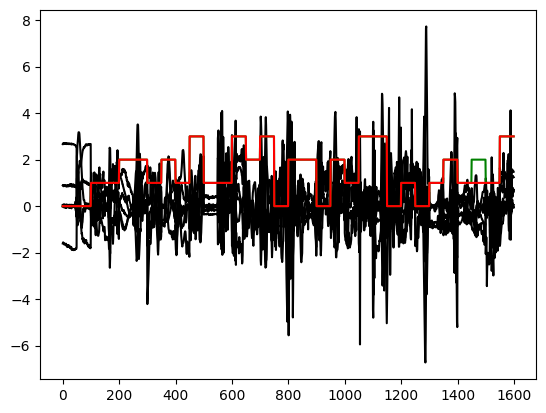

In [ ]:
model = TransformerModel().to(device)
model.load_state_dict(torch.load('./saved_model/transformer_model.pth'))
for i, (images, labels) in enumerate(train_dataloader):
    # Forward pass
    images = images.float().to(device)
    labels = labels.squeeze().long().to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    reshaped_images = images.view(-1, 6)
    pred = torch.argmax(outputs, dim=1)

    plt.plot(reshaped_images.cpu().numpy(), color='black')
    # for each pred, repeat it for 50 times: 
    plt.plot(np.repeat(pred.cpu().numpy(), 50), color='green')
    # for each label, do the same:
    plt.plot(np.repeat(labels.cpu().numpy(), 50), color='red')
    plt.show()
    break
    
    
    
    
    

In [ ]:
!pip install easyfsl
from easyfsl.samplers import TaskSampler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 1.9 MB/s eta 0:00:00


In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores
    

In [ ]:
backbone_model = TransformerModel().to(device)
backbone_model.load_state_dict(torch.load('./saved_model/transformer_model.pth'))

backbone_model.psi = nn.Flatten()
prototype_model = PrototypicalNetworks(backbone_model).to(device)

/Users/davidwang/opt/anaconda3/envs/research/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100
test_set = MultivariateTimeSeriesDataset(test_X, test_Y, transform=ST)
# check each class has what number of samples:

test_set.get_labels = lambda: test_set.Y

test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

ValueError: Label 0 has only 1 samplesbut all classes must have at least n_shot + n_query (15) samples.